<a href="https://colab.research.google.com/github/WoradeeKongthong/stock_price_time_series/blob/master/01_stockPrice_univariateMLP_singleStepOutput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MLP : time series forcasting with 1 feature input and 1 step output**

In [0]:
import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

# Dataset : google stock price (2015-2019) from yahoo.com

In [53]:
df = DataReader('GOOG', data_source='yahoo', start='2015-01-01', end='2019-12-31')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,529.815369,522.665039,527.561584,523.373108,1447500.0,523.373108
2015-01-05,522.894409,511.655243,521.827332,512.463013,2059800.0,512.463013
2015-01-06,514.761719,499.678131,513.589966,500.585632,2899900.0,500.585632
2015-01-07,505.855164,498.281952,505.611847,499.727997,2065000.0,499.727997
2015-01-08,502.101471,489.655640,496.626526,501.303680,3353500.0,501.303680


In [54]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,529.815369,522.665039,527.561584,523.373108,1447500.0,523.373108
2015-01-05,522.894409,511.655243,521.827332,512.463013,2059800.0,512.463013
2015-01-06,514.761719,499.678131,513.589966,500.585632,2899900.0,500.585632
2015-01-07,505.855164,498.281952,505.611847,499.727997,2065000.0,499.727997
2015-01-08,502.101471,489.655640,496.626526,501.303680,3353500.0,501.303680
...,...,...,...,...,...,...
2019-12-24,1350.260010,1342.780029,1348.500000,1343.560059,347500.0,1343.560059
2019-12-26,1361.327026,1344.469971,1346.170044,1360.400024,667500.0,1360.400024
2019-12-27,1364.530029,1349.310059,1362.989990,1351.890015,1038400.0,1351.890015


#  Get X from Dataframe
Time series to train the model is the 'Close' price.  

In [0]:
data = df.loc[:, ['Close']].values

In [56]:
data.shape

(1258, 1)

# Data Preprocessing

In [0]:
# Feature Scaling on the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
data_scaled = sc.fit_transform(data)

In [58]:
# check the shape of preprocessed data
print(data_scaled.shape)
data_scaled

(1258, 1)


array([[0.03698029],
       [0.0244395 ],
       [0.01078684],
       ...,
       [0.98933292],
       [0.97122881],
       [0.97224035]])

# Create timestep sequence
X : n_steps sequence of data  
y : 1 step output

In [0]:
def create_sequence(data, n_steps):
  X = []
  y = []
  for i in range(n_steps, len(data)):
    X.append(data[i - n_steps:i])
    y.append(data[i])
  return np.array(X), np.array(y)

In [0]:
# choose number of timesteps
n_steps = 60
# Create the sequence and the output
X,y = create_sequence(data_scaled, n_steps)

# MLP model need X dimension to be [samples, timesteps]
X = X.reshape(X.shape[0],X.shape[1])
y = y.reshape(y.shape[0],)  

In [61]:
print('X shape : ',X.shape)
print('y shape : ',y.shape)

X shape :  (1198, 60)
y shape :  (1198,)


# MLP model

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten

In [0]:
# define MLP model
model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=n_steps))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

# Train MLP

In [0]:
history = model.fit(X, y, epochs = 1000, verbose = 0)

training loss :  0.04863194769165962


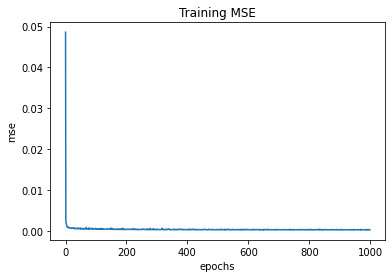

In [65]:
score = history.history['loss'][0]
print('training loss : ', score)

plt.plot(history.history['loss'])
plt.title('Training MSE')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.show()

Model Evaluation : 
MSE :  174.23865969599424
RMSE :  13.19994923081124


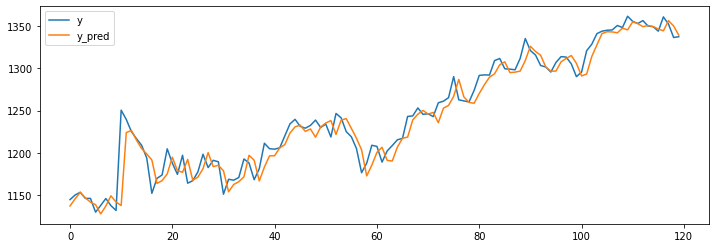

In [74]:
y_pred = model.predict(X)

# inverse transform the price
y = sc.inverse_transform(y.reshape(len(y),1))
y_pred = sc.inverse_transform(y_pred.reshape(len(y_pred),1))

# calculate rmse
mse = mean_squared_error(y, y_pred)
rmse = sqrt(mse)
print('Model Evaluation : ')
print('MSE : ', mse) 
print('RMSE : ', rmse)

# plot
plt.figure(figsize=(12,4))
plt.plot(y[-120:])
plt.plot(y_pred[-120:])
plt.legend(['y','y_pred'])
plt.show()

# Model Evaluation : walk forward validation

In [76]:
# get the test set : Jan - March of 2020
df = DataReader('GOOG', data_source='yahoo', start='2020-01-01', end='2020-03-31')
test = df.loc[:,['Close']].values

# feature scaling on the test set
test = sc.transform(test)

# seed the last n_steps in training dataset
history = data_scaled[-n_steps:]

# create timestep sequence for the training set
test = np.concatenate((history, test), axis=0)
X_test, y_test = create_sequence(test, n_steps)
# MLP model need X dimension to be [samples, timesteps]
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1])
#y_test = y_test.reshape(y_test.shape[0],) 
print('X_test shape : ',X_test.shape)
print('y_test shape : ',y_test.shape)

X_test shape :  (62, 60)
y_test shape :  (62, 1)


In [0]:
# Make predictions
y_pred = model.predict(X_test)

In [0]:
# inverse transform y_test and y_pred 
y_test = sc.inverse_transform(y_test)
y_pred = sc.inverse_transform(y_pred)

In [79]:
# calculate rmse
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print('Model Evaluation : ')
print('MSE : ', mse) 
print('RMSE : ', rmse)

Model Evaluation : 
MSE :  1652.8419335434057
RMSE :  40.65515875683436


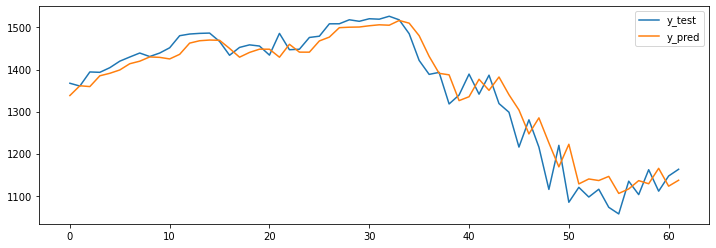

In [80]:
# plot
plt.figure(figsize=(12,4))
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['y_test','y_pred'])
plt.show()